## Data preprocessing

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import lognorm

In [3]:
""" data_path = "/home/onyx/Documents/MEMOIRE/memoire/data/sales_train_evaluation.csv"
pkl_path = "/home/onyx/Documents/MEMOIRE/memoire/data/sales_train_evaluation.pkl" """
data_path = "/home/onyx/Documents/Mémoire/memoire/data/sales_train_evaluation.csv"
pkl_path = "/home/onyx/Documents/Mémoire/memoire/data/sales_train_evaluation.pkl"
cal_path = "/home/onyx/Documents/Mémoire/memoire/data/calendar.csv"

REVIEW_TIME = 1
LEAD_TIME = 2

alpha = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.975, 0.99]

In [4]:
def load_data(data_path: str) -> pd.DataFrame:
    """
    Load data from a CSV or pickle file into a pandas DataFrame.
    
    Parameters:
        data_path (str): Path to the data file, can be CSV or pickle.
    
    Returns:
        pd.DataFrame: Loaded DataFrame.
    """
    if data_path.endswith(".csv"):
        # Load the CSV file
        df = pd.read_csv(data_path)
        df.to_pickle(pkl_path)
    elif data_path.endswith(".pkl"):
        # Load the pickle file
        df = pd.read_pickle(pkl_path)
    else:
        raise ValueError("Unsupported file format. Please use .csv or .pkl")

    return df

In [5]:
def scraping_high_zeroes_products(df: pd.DataFrame, n: int) -> pd.DataFrame:
    # Count the number of zeroes in each row
    df['zero_count'] = (df == 0).sum(axis=1)
    
    # Sort the DataFrame by the number of zeroes in ascending order
    df_sorted = df.sort_values(by='zero_count')
    
    # Keep only the top 1000 rows with the least number of zeroes
    df_top_n = df_sorted.head(n)
    
    # Drop the 'zero_count' column as it is no longer needed
    df_top_n = df_top_n.drop(columns=['zero_count'])
    
    return df_top_n

def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocess the DataFrame by removing unnecessary columns and converting
    the demand columns to numeric types.
    
    Parameters:
        df (pd.DataFrame): Original DataFrame.
    
    Returns:
        pd.DataFrame: Demand matrix with product 'id' as index and days as columns.
    """
    # Remove unnecessary columns
    df_demand = df.drop(columns=['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])
    # Set 'id' as index
    demand_matrix = df_demand.set_index('id')

    # Load the calendar.csv file
    calendar = pd.read_csv(cal_path)

    # Get the date columns from the calendar dataframe
    date_columns = calendar['date']
    demand_matrix.columns = date_columns[0:demand_matrix.shape[1]]
    
    
    return demand_matrix

def analyse_data(df: pd.DataFrame) -> [pd.Series, pd.Series]:
    means = df.mean(axis=1)
    stds = df.std(axis=1)
    
    return means, stds



# Forecast Computing  

ATTENTION, data leakage, décaller les forecast du lead time pour éviter les accès au futur.

Forecast computed on the average of the three lasts day sales

In [6]:
def FC_avg_n_days(demand_matrix: pd.DataFrame, n: int) -> pd.DataFrame:
    """
    Compute the forecast by averaging the last n days for each product.
    
    Parameters:
        demand_matrix (pd.DataFrame): Demand matrix.
    
    Returns:
        pd.DataFrame: Forecast matrix (rounded up).
    """
    forecast_matrix = demand_matrix.T.rolling(window=n).mean().shift(1+REVIEW_TIME+LEAD_TIME).T
    return forecast_matrix

def FC_med_n_days(demand_matrix: pd.DataFrame, n: int) -> pd.DataFrame:
    """
    Compute the forecast by averaging the last n days for each product.
    
    Parameters:
        demand_matrix (pd.DataFrame): Demand matrix.
    
    Returns:
        pd.DataFrame: Forecast matrix (rounded up).
    """
    forecast_matrix = demand_matrix.T.rolling(window=n).median().shift(1+REVIEW_TIME+LEAD_TIME).T
    return forecast_matrix

def FC_avg_n_same_days(demand_matrix: pd.DataFrame, n: int) -> pd.DataFrame:
    """
    Compute the forecast by averaging the same day of the week over the previous 4 weeks for each product.
    
    Parameters:
        demand_matrix (pd.DataFrame): Demand matrix.
    
    Returns:
        pd.DataFrame: Weekly forecast matrix (rounded up).
    """
    demand_np = demand_matrix.to_numpy()
    n_products, n_days = demand_np.shape
    weekly_forecast_np = np.full((n_products, n_days), np.nan)
    
    # For each day of the week (offset from 0 to 6)
    for offset in range(7):
        idx = np.arange(offset, n_days, 7)
        # Need at least 5 weeks to use the previous n weeks
        if len(idx) < n+1:
            continue
        # Create a sliding window view for the previous n weeks
        slices = np.stack([demand_np[:, idx[i: i + len(idx) - n]] for i in range(1,n)], axis=-1)
        rolling_mean = np.mean(slices, axis=-1)
        target_indices = idx[n:]  # Days to forecast
        weekly_forecast_np[:, target_indices] = rolling_mean
        
    weekly_forecast_matrix = pd.DataFrame(
        weekly_forecast_np,
        index=demand_matrix.index,
        columns=demand_matrix.columns
    )
    return weekly_forecast_matrix

def FC_med_n_same_days(demand_matrix: pd.DataFrame, n: int) -> pd.DataFrame:
    """
    Compute the forecast by taking the median of the same day of the week over the previous 4 weeks for each product.
    
    Parameters:
        demand_matrix (pd.DataFrame): Demand matrix.
    
    Returns:
        pd.DataFrame: Weekly forecast matrix (rounded up).
    """
    demand_np = demand_matrix.to_numpy()
    n_products, n_days = demand_np.shape
    weekly_forecast_np = np.full((n_products, n_days), np.nan)
    
    # For each day of the week (offset from 0 to 6)
    for offset in range(7):
        idx = np.arange(offset, n_days, 7)
        # Need at least n+1 weeks to use the previous n weeks
        if len(idx) < n+1:
            continue
        # Create a sliding window view for the previous n weeks
        slices = np.stack([demand_np[:, idx[i: i + len(idx) - n]] for i in range(1,n)], axis=-1)
        rolling_med = np.median(slices, axis=-1)
        target_indices = idx[n:]  # Days to forecast
        weekly_forecast_np[:, target_indices] = rolling_med
        
    weekly_forecast_matrix = pd.DataFrame(
        weekly_forecast_np,
        index=demand_matrix.index,
        columns=demand_matrix.columns
    )
    return weekly_forecast_matrix

# Safety stock

In [7]:
def SS_cst(demand_matrix: pd.DataFrame, forecast_matrix: pd.DataFrame, safety_stock_value: int, R: int) -> pd.DataFrame:
    """
    Create a safety stock matrix with a constant integer value for each product and each day.
    
    Parameters:
        demand_matrix (pd.DataFrame): Demand matrix with product index and days as columns.
        safety_stock_value (int): The safety stock level to assign.
    
    Returns:
        pd.DataFrame: Safety stock matrix with the same shape as demand_matrix, filled with safety_stock_value.
    """
    safety_stock_matrix = pd.DataFrame(
        safety_stock_value,
        index=demand_matrix.index,
        columns=demand_matrix.columns
    )
    return safety_stock_matrix

def SS_on_forecast(demand_matrix: pd.DataFrame, forecast_matrix: pd.DataFrame, safety_stock_factor: int, R: int) -> pd.DataFrame:
    """
    Create a safety stock matrix constituted of the n+3 day of forecast times the safety_stock_factor.

    Parameters:
        demand_matrix (pd.DataFrame): Demand matrix with product index and days as columns.
        safety_stock_factor: The factor to apply to the forecasted demand.

    Returns:
        pd.DataFrame: Safety stock matrix with the same shape as demand_matrix, filled with safety_stock_value.
    """
    safety_stock_matrix = pd.DataFrame(
        safety_stock_factor * forecast_matrix.shift(-R, axis=1).values,
        index=demand_matrix.index,
        columns=demand_matrix.columns
    )
    return safety_stock_matrix


# Up-to-level

In [8]:
def up_to_level_optimal_restock(demand_matrix, forecast_matrix: pd.DataFrame, safety_stock_matrix: pd.DataFrame, X, min_fill_rate, R):
    """
    Find the optimal fixed restock level that reaches the minimal fill rate.
    
    Parameters:
        min_fill_rate (float): The minimum fill rate to achieve.
    
    Returns:
        int: The optimal fixed restock level.
    """
    demand = demand_matrix.to_numpy()
    up_to_level = np.ones(demand_matrix.shape)
    _, _, _, _, _, lost_sales = compute_stock(up_to_level, demand)
    fill_rates_per_product = compute_fill_rates_per_product(lost_sales, demand)

    while not (fill_rates_per_product > min_fill_rate).all():
        _, _, _, _, _, lost_sales = compute_stock(up_to_level, demand)
        fill_rates_per_product = compute_fill_rates_per_product(lost_sales, demand)
        goods = np.where(fill_rates_per_product <= min_fill_rate)
        up_to_level[goods] += 1
    
    for i in range(up_to_level.shape[1]):
        if i + R <= up_to_level.shape[1]:
            up_to_level[:, i] = np.sum(up_to_level[:, i:i+R], axis=1)
        else:
            up_to_level[:, i] = np.sum(up_to_level[:, :], axis=1)
    
    return pd.DataFrame(up_to_level, index=demand_matrix.index, columns=demand_matrix.columns)

def compute_fill_rates_per_product(lost_sales, demand):
    """Compute the fill rate for each product
    
    Parameters:
        lost_sales (ndarray): Numpy array of lost sales.
        demand (ndarray): Numpy array of demand.
        
    Returns:
        ndarray: Numpy array of fill rates.
    """
    return 1 - lost_sales.sum(axis=1) / demand.sum(axis=1)
    

In [9]:
def up_to_level_on_forecast(demand_matrix, forecast_matrix: pd.DataFrame, safety_stock_matrix: pd.DataFrame, X, min_fill_rate, R):
    """
    Compute the forecast by summing the demand of the next 3 days for each product.
    
    Parameters:
        demand_matrix (pd.DataFrame): Demand matrix.
    
    Returns:
        pd.DataFrame: Forecast matrix (rounded up).
    """
    up_to_level_matrix = forecast_matrix.T.shift(-R+1).rolling(window=R).sum().T
    up_to_level_matrix += safety_stock_matrix
    
    return np.ceil(up_to_level_matrix)

def up_to_level_fixed_X(demand_matrix, forecast_matrix: pd.DataFrame, safety_stock_matrix: pd.DataFrame, X, min_fill_rate, R):
    ones = np.ones(demand_matrix.shape)
    up_to_level = ones * X
    up_to_level_matrix = pd.DataFrame(up_to_level, index=demand_matrix.index, columns=demand_matrix.columns)
    
    up_to_level = up_to_level_matrix.to_numpy()

    for i in range(up_to_level.shape[1]):
        if i + R <= up_to_level.shape[1]:
            up_to_level[:, i] = np.sum(up_to_level[:, i:i+R], axis=1)
        else:
            up_to_level[:, i] = np.sum(up_to_level[:, :], axis=1)

    up_to_level_matrix = pd.DataFrame(up_to_level, index=demand_matrix.index, columns=demand_matrix.columns)

    return up_to_level_matrix


In [10]:
def up_to_level_normal_demand( #TODO: DATA LEAKAGE
    demand_matrix: pd.DataFrame,
    forecast_matrix,       # non utilisé mais conservé pour pipeline
    safety_stock_matrix,   # idem
    X,                     # idem
    min_fill_rate: float, #CSL
    window_size: int = 14  # taille de la fenêtre glissante
) -> pd.DataFrame:
    """
    Même principe que before, mais on ne regarde que les `window_size` derniers jours
    pour estimer mean et std avant le jour j.
    """
    # 1) Rolling stats (on prend j−window_size à j−1, puis shift pour ne pas prendre j)
    roll_means = demand_matrix.rolling(
        window=window_size, axis=1, min_periods=1
    ).mean().shift(1+REVIEW_TIME+LEAD_TIME, axis=1).fillna(0)
    roll_stds = demand_matrix.rolling(
        window=window_size, axis=1, min_periods=1
    ).std(ddof=0).shift(1+REVIEW_TIME+LEAD_TIME, axis=1).fillna(0)

    # 2) Quantile
    quantiles = pd.DataFrame(
        norm.ppf(min_fill_rate, loc=roll_means.values, scale=roll_stds.values),
        index=demand_matrix.index,
        columns=demand_matrix.columns
    ).clip(lower=0)

    # 3) Somme glissante sur R jours
    n_days = demand_matrix.shape[1]
    up_to = pd.DataFrame(0, index=demand_matrix.index, columns=demand_matrix.columns)
    for j in range(n_days):
        end = min(j + REVIEW_TIME + LEAD_TIME, n_days)
        up_to.iloc[:, j] = quantiles.iloc[:, j:end].sum(axis=1)

    return np.ceil(up_to)

def up_to_level_lognormal_demand(
    demand_matrix: pd.DataFrame,
    forecast_matrix,       # non utilisé mais conservé pour pipeline
    safety_stock_matrix,   # idem
    X,                     # idem
    min_fill_rate: float, #CSL
    R: int,
    window_size: int = 14  # taille de la fenêtre glissante
) -> pd.DataFrame:
    """
    Même principe que before, mais on ne regarde que les `window_size` derniers jours
    pour estimer mean et std avant le jour j, avec une distribution log-normale.
    """
    # 1) Rolling stats (on prend j−window_size à j−1, puis shift)
    roll_means = demand_matrix.rolling(window=window_size, axis=1, min_periods=1).mean().shift(1, axis=1).fillna(0)
    roll_stds = demand_matrix.rolling(window=window_size, axis=1, min_periods=1).std(ddof=0).shift(1, axis=1).fillna(0)
    
    # 2) Convertir roll_means et roll_stds vers les paramètres de la lognormale
    # On suppose que roll_means > 0 pour effectuer le logarithme
    sigma = np.sqrt(np.log(1 + (roll_stds / roll_means)**2))
    mu = np.log(roll_means) - 0.5 * sigma**2

    # 3) Calculer le quantile en utilisant la lognormale : scale = exp(mu), s = sigma 
    quantile_vals = lognorm.ppf(min_fill_rate, s=sigma, scale=np.exp(mu))
    quantiles = pd.DataFrame(quantile_vals, index=demand_matrix.index, columns=demand_matrix.columns).clip(lower=0)
    
    # 4) Somme glissante sur R jours
    n_days = demand_matrix.shape[1]
    up_to = pd.DataFrame(0, index=demand_matrix.index, columns=demand_matrix.columns)
    for j in range(n_days):
        end = min(j + R, n_days)
        up_to.iloc[:, j] = quantiles.iloc[:, j:end].sum(axis=1)
    
    return np.ceil(up_to)

# Inventory

In [ ]:
def compute_stock(up_to_level, demand, order_rate=REVIEW_TIME):
    """
    Compute various stock management indicators:
      - inventory_begin: stock at the beginning of the day
      - inventory_end: stock at the end of the day
      - T1: stock arriving in 1 day
      - T2: stock arriving in 2 days
      - sales: actual sales
      - lost_sales: unmet demand (lost sales)
    
    Parameters:
        up_to_level (ndarray): Matrix of levels to reach.
        demand (ndarray): Demand matrix.
        order_rate (int): Interval of days between orders.
    
    Returns:
        tuple of pd.DataFrame: DataFrames for inventory_begin, inventory_end, T1, T2, sales, and lost_sales.
    """

    """ # Conversion vers arrays
    demand = demand_matrix.to_numpy()
    up_to_level = up_to_level_matrix.to_numpy()
    # Ensure no NaN values in the matrices """
    np.nan_to_num(up_to_level, copy=False)

    n_products, n_days = demand.shape

    # Initialisation des arrays
    inventory_begin = np.zeros_like(demand)
    inventory_end = np.zeros_like(demand)
    T1 = np.zeros_like(demand)
    T2 = np.zeros_like(demand)
    sales = np.zeros_like(demand)
    lost_sales = np.zeros_like(demand)
    T2[:, 0] = up_to_level[:, 0] - inventory_begin[:, 0]
    inventory_end[:, 0] = np.maximum(inventory_begin[:, 0] - demand[:, 0], 0)
    sales[:, 0] = inventory_begin[:, 0] - inventory_end[:, 0]
    lost_sales[:, 0] = np.maximum(demand[:, 0] - sales[:, 0], 0)

    # Boucle vectorisée jour par jour
    for day in range(1, n_days):
        T1[:, day] = T2[:, day - 1]
        inventory_begin[:, day] = inventory_end[:, day - 1] + T1[:, day - 1]
        inventory_end[:, day] = np.maximum(inventory_begin[:, day] - demand[:, day], 0)

        if(day%order_rate == 0):
            T2[:, day] = np.nan_to_num(np.maximum(up_to_level[:, day] - inventory_end[:, day] - T1[:, day], 0))
        sales[:, day] = inventory_begin[:, day] - inventory_end[:, day]
        lost_sales[:, day] = np.maximum(demand[:, day] - sales[:, day], 0)

    return inventory_begin, inventory_end, T1, T2, sales, lost_sales

#inventory_begin, inventory_end, _, _, _, lost_sales = compute_stock(up_to_level_matrix.to_numpy(), demand_matrix.to_numpy())

def compute_stock_Q_s(Q, s, demand):
    """
    Compute stock management indicators for a (Q,s) policy.
    
    Returns:
        tuple of pd.DataFrame: DataFrames for inventory_begin, inventory_end, T1, T2, sales, and lost_sales.
    """

    np.nan_to_num(Q, copy=False)

    _, n_days = demand.shape

    # Arrays init
    inventory_begin = np.zeros_like(demand)
    inventory_end = np.zeros_like(demand)
    T1 = np.zeros_like(demand)
    T2 = np.zeros_like(demand)
    sales = np.zeros_like(demand)
    lost_sales = np.zeros_like(demand)

    #Day 0 init
    inventory_begin[:, 0] = 5
    T1[:, 0] = 0
    # Si le stock initial est inférieur ou égal à s, on commande Q[:,0] unités
    reorder_mask = inventory_begin[:, 0] <= s[:, 0]
    T2[:, 0] = np.where(reorder_mask, Q[:, 0], 0)
    inventory_end[:, 0] = np.maximum(inventory_begin[:, 0] - demand[:, 0], 0)
    sales[:, 0] = inventory_begin[:, 0] - inventory_end[:, 0]
    lost_sales[:, 0] = np.maximum(demand[:, 0] - sales[:, 0], 0)

    for day in range(1, n_days):
        T1[:, day] = T2[:, day - 1]
        inventory_begin[:, day] = inventory_end[:, day - 1] + T1[:, day - 1]
        inventory_end[:, day] = np.maximum(inventory_begin[:, day] - demand[:, day], 0)

        # Si le stock après vente est inférieur ou égal à s[:,day], on commande Q[:,day] unités
        reorder_mask = inventory_end[:, day] <= s[:, day]
        T2[:, day] = np.where(reorder_mask, Q[:, day], 0)

        sales[:, day] = inventory_begin[:, day] - inventory_end[:, day]
        lost_sales[:, day] = np.maximum(demand[:, day] - sales[:, day], 0)

    return inventory_begin, inventory_end, T1, T2, sales, lost_sales


# Performance metrics

In [ ]:
def compute_results(demand, lost_sales, inventory_begin, inventory_end, n_days):
    """
    Compute overall stock management metrics:
      - Fill rate
      - Average inventory
      - Ratio of days with perfect service (no lost sales)
    
    Parameters:
        demand_matrix (pd.DataFrame): Demand matrix.
        forecast_matrix (pd.DataFrame): Forecast matrix.
        up_to_level_matrix (pd.DataFrame): Matrix of levels to reach.
    
    Returns:
        dict: Dictionary containing the results.
    """

    fill_rate = 1 - lost_sales.sum().sum() / demand.sum().sum()
    avg_inventory = (inventory_begin.sum().sum() + inventory_end.sum().sum()) / 2 // n_days
    # Compute the average percentage of products containing lost sales per day
    products_with_lost_sales = (lost_sales > 0).sum(axis=0)/lost_sales.shape[0]
    average_percentage_lost_sales = products_with_lost_sales.mean()
    
    return fill_rate, avg_inventory, average_percentage_lost_sales

def compute_pareto(_forecast_func=None, _fc_factor=None,
                    _ss_func=SS_cst, _ss_factor=0,
                    _up_to_level_func=None, _X=None, _min_fill_rate=None,
                    _compute_stock_func=None, _order_rate=REVIEW_TIME):
    results = {}

    if type(_ss_factor) == list:
        for i in _ss_factor:
            fill_rate, avg_inventory, average_percentage_lost_sales = pipeline(
                forecast_func=_forecast_func, fc_factor=_fc_factor,
                ss_func=_ss_func, ss_factor=i,
                up_to_level_func=_up_to_level_func, X=_X, min_fill_rate=_min_fill_rate,
                compute_stock_func=_compute_stock_func, order_rate=_order_rate
            )
            results[i] = (fill_rate, avg_inventory, average_percentage_lost_sales)
    elif type(_X) == list:
        for i in _X:
            fill_rate, avg_inventory, average_percentage_lost_sales = pipeline(
                forecast_func=_forecast_func, fc_factor=_fc_factor,
                ss_func=_ss_func, ss_factor=_ss_factor,
                up_to_level_func=_up_to_level_func, X=i, min_fill_rate=_min_fill_rate,
                compute_stock_func=_compute_stock_func, order_rate=_order_rate
            )
            results[i] = (fill_rate, avg_inventory, average_percentage_lost_sales)
    elif type(_min_fill_rate) == list:
        for i in _min_fill_rate:
            fill_rate, avg_inventory, average_percentage_lost_sales = pipeline(
                forecast_func=_forecast_func, fc_factor=_fc_factor,
                ss_func=_ss_func, ss_factor=_ss_factor,
                up_to_level_func=_up_to_level_func, X=_X, min_fill_rate=i,
                compute_stock_func=_compute_stock_func, order_rate=_order_rate
            )
            results[i] = (fill_rate, avg_inventory, average_percentage_lost_sales)
    elif type(_order_rate) == list:
        for i in _order_rate:
            fill_rate, avg_inventory, average_percentage_lost_sales = pipeline(
                forecast_func=_forecast_func, fc_factor=_fc_factor,
                ss_func=_ss_func, ss_factor=_ss_factor,
                up_to_level_func=_up_to_level_func, X=_X, min_fill_rate=_min_fill_rate,
                compute_stock_func=_compute_stock_func, order_rate=i
            )
            results[i] = (fill_rate, avg_inventory, average_percentage_lost_sales)
    else : 
        raise ValueError("No variable to iterate over")
    
    return results

def compute_pareto_Q_s(demand_matrix, forecast_matrix, CSLs):
    """
    Compute the (Q,s) policy results for different CSLs.
    
    Parameters:
        demand_matrix (pd.DataFrame): Demand matrix.
        forecast_matrix (pd.DataFrame): Forecast matrix.
        CSLs (list): List of CSL values to evaluate.
    
    Returns:
        dict: Dictionary containing the results for each CSL.
    """

    results = {}
    _, n_days = demand_matrix.shape

    Q_matrix = np.ceil(forecast_matrix.T.shift(-3+1).rolling(window=3).sum().T) #n = 3

    for CSL in CSLs:
        s_matrix = up_to_level_lognormal_demand(demand_matrix=demand_matrix,
                                                        forecast_matrix=None,
                                                        safety_stock_matrix=None,
                                                        X=None,
                                                        min_fill_rate=CSL, #CSL
                                                        R=REVIEW_TIME,
                                                        window_size=30)

        inventory_begin, inventory_end, T1, T2, sales, lost_sales = compute_stock_Q_s(Q_matrix.to_numpy(), s_matrix.to_numpy(), demand_matrix.to_numpy())
        results[CSL] = compute_results(demand_matrix, lost_sales, inventory_begin, inventory_end, n_days)
        
    return results

In [13]:
def compute_fill_rates_per_product(lost_sales, demand):
    """Compute the fill rate for each product
    
    Parameters:
        lost_sales (ndarray): Numpy array of lost sales.
        demand (ndarray): Numpy array of demand.
        
    Returns:
        ndarray: Numpy array of fill rates.
    """
    return 1 - lost_sales.sum(axis=1) / demand.sum(axis=1)

In [14]:
#KPIs forecasts
def mape(demand, forecast):
    mask = demand != 0
    return np.mean(np.abs((demand[mask] - forecast[mask]) / demand[mask])) * 100

def rmse(demand, forecast):
    return np.sqrt(np.mean((demand - forecast)**2))

def mae(demand, forecast):
    return np.mean(np.abs(demand - forecast))

def bias(demand, forecast):
    return np.mean(forecast - demand)

def smape(demand, forecast):
    denominator = (np.abs(demand) + np.abs(forecast)) / 2
    mask = denominator != 0
    return np.mean(np.abs(demand[mask] - forecast[mask]) / denominator[mask]) * 100

# Plots

In [77]:
def plot_stocks(demand_matrix, forecast_matrix, lost_sales, inventory_begin, inventory_end):
    
    # Transform in pd.DataFrame
    lost_sales_matrix = pd.DataFrame(lost_sales, index=demand_matrix.index, columns=demand_matrix.columns)
    inventory_begin_matrix = pd.DataFrame(inventory_begin, index=demand_matrix.index, columns=demand_matrix.columns)
    inventory_end_matrix = pd.DataFrame(inventory_end, index=demand_matrix.index, columns=demand_matrix.columns)

    # Scrap the first 7 days for the plot  
    demand_matrix = demand_matrix.iloc[:, 7:]
    forecast_matrix = forecast_matrix.iloc[:, 7:]
    lost_sales_matrix = lost_sales_matrix.iloc[:, 7:]
    inventory_begin_matrix = inventory_begin_matrix.iloc[:, 7:]
    inventory_end_matrix = inventory_end_matrix.iloc[:, 7:]
    
    # Agrégation
    total_demand = demand_matrix.sum(axis=0)
    total_forecast = forecast_matrix.sum(axis=0)
    total_inventory = (inventory_begin_matrix.sum(axis=0) + inventory_end_matrix.sum(axis=0)) / 2
    total_lost_sales = lost_sales_matrix.sum(axis=0)

    # Paramètres de style
    #plt.style.use('seaborn-whitegrid')
    plt.figure(figsize=(15, 6))

    # Tracés
    plt.plot(total_demand, label='Demand', color='dodgerblue', linewidth=1.5)
    plt.plot(total_forecast, label='Forecast', color='orangered', linewidth=1.5)
    plt.plot(total_lost_sales, label='Lost Sales', color='limegreen', linewidth=1.2)
    plt.plot(total_inventory, label='Average Inventory', color='saddlebrown', linewidth=1.5)

    # Améliorations visuelles
    plt.title('Daily Aggregated Metrics', fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Units', fontsize=12)
    plt.xticks(rotation=45)
    plt.tick_params(axis='x', labelsize=8)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(loc='upper right', frameon=True, framealpha=0.9)

    # Limiter les xticks pour lisibilité
    xtick_interval = 60  # afficher 1 tick tous les 60 jours
    plt.xticks(ticks=range(0, len(total_demand), xtick_interval),
            labels=total_demand.index[::xtick_interval], rotation=45)

    plt.tight_layout()
    plt.show()
    
    
def plot_smooth_n_days(demand_matrix, forecast_matrix, lost_sales, inventory_begin, inventory_end, rolling_window):
    # Transform in pd.DataFrame
    lost_sales_matrix = pd.DataFrame(lost_sales, index=demand_matrix.index, columns=demand_matrix.columns)
    inventory_begin_matrix = pd.DataFrame(inventory_begin, index=demand_matrix.index, columns=demand_matrix.columns)
    inventory_end_matrix = pd.DataFrame(inventory_end, index=demand_matrix.index, columns=demand_matrix.columns)

    # Scrap the first 7 days for the plot  
    demand_matrix = demand_matrix.iloc[:, 7:]
    forecast_matrix = forecast_matrix.iloc[:, 7:]
    lost_sales_matrix = lost_sales_matrix.iloc[:, 7:]
    inventory_begin_matrix = inventory_begin_matrix.iloc[:, 7:]
    inventory_end_matrix = inventory_end_matrix.iloc[:, 7:]

    # Agrégation
    total_demand = demand_matrix.sum(axis=0)
    total_forecast = forecast_matrix.sum(axis=0)
    total_inventory = (inventory_begin_matrix.sum(axis=0) + inventory_end_matrix.sum(axis=0)) / 2
    total_lost_sales = lost_sales_matrix.sum(axis=0)

    # Moyennes glissantes (n jours)
    smoothed_demand = total_demand.rolling(window=rolling_window).mean()
    smoothed_forecast = total_forecast.rolling(window=rolling_window).mean()
    smoothed_inventory = total_inventory.rolling(window=rolling_window).mean()
    smoothed_lost_sales = total_lost_sales.rolling(window=rolling_window).mean()
    
    
    # Paramètres de style
    #plt.style.use('seaborn-whitegrid')
    plt.figure(figsize=(15, 6))

    # Tracés
    plt.plot(smoothed_demand, label='Demand (Smoothed)', color='dodgerblue')
    plt.plot(smoothed_forecast, label='Forecast (Smoothed)', color='orangered')
    plt.plot(smoothed_lost_sales, label='Lost Sales (Smoothed)', color='limegreen')
    plt.plot(smoothed_inventory, label='Avg Inventory (Smoothed)', color='saddlebrown')

    # Améliorations visuelles
    plt.title('Smoothed Metrics ('+str(rolling_window)+'-Day Rolling)', fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Units', fontsize=12)
    plt.xticks(rotation=45)
    plt.tick_params(axis='x', labelsize=8)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(loc='upper right', frameon=True, framealpha=0.9)
    
    # Limiter les xticks pour lisibilité
    xtick_interval = 60  # afficher 1 tick tous les 60 jours
    plt.xticks(ticks=range(0, len(total_demand), xtick_interval),
            labels=total_demand.index[::xtick_interval], rotation=45)
    plt.tight_layout()
    plt.show()

def plot_histogram(df):
    means, stds = analyse_data(df)

    # Écart type global sur les valeurs aplaties
    sd = np.std(df.values.flatten())

    # Filtrage des valeurs <= 2*écart-type
    filtered_data = df[df <= 2 * sd]

    # Histogramme
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(filtered_data.values.flatten(), bins=50)
    mean = means.mean()
    plt.axvline(x=mean, color='red', linestyle='--')
    plt.text(mean, 0, 'mu', color='red', verticalalignment='bottom')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title('Histogram of Values in the Demand')

    # Q-Q plot des log(données)
    plt.subplot(1, 2, 2)
    flattened = filtered_data.values.flatten()
    log_data = np.log(flattened[flattened > 0])  # filtrer les zéros ou négatifs
    stats.probplot(log_data, dist="norm", plot=plt)
    plt.title("Q-Q Plot of log(Values)")

    plt.tight_layout()
    plt.show()

def plot_pareto(policy_results):
    # Sort the results by average inventory
    sorted_items = sorted(policy_results.items(), key=lambda x: x[1][1])
    Variables = [item[0] for item in sorted_items]
    fill_rates = [item[1][0] for item in sorted_items]
    avg_inventories = [item[1][1] for item in sorted_items]
    
    plt.figure(figsize=(8, 6))
    plt.plot(avg_inventories, fill_rates, marker='o', linestyle='-', color='blue', label='Frontier')
    
    # Annotate the points with variables values
    for inv, fr, name in zip(avg_inventories, fill_rates, Variables):
        plt.annotate(name, (inv, fr), textcoords="offset points", xytext=(0,5), ha='center')
    
    plt.xlabel("Fill Rate")
    plt.ylabel("Average Inventory")
    plt.title("Strategy Results (Average Inventory vs. Fill Rate)")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_results(results, filter=None):
    fc_filters = ['moving_avg_3', 'moving_avg_7', 'moving_avg_14', 'same_days_avg_4', 'same_days_avg_8', 'same_days_med_4', 'same_days_med_8']
    policy_filters = ['theoretical', 'Q_s', 'dynamic']

    plt.figure(figsize=(15, 10))

    # Determine color mapping based on filter
    if filter == 'policy':
        # Assign a color to each policy type
        cmap = plt.get_cmap('tab10')
        color_map = {policy: cmap(i) for i, policy in enumerate(policy_filters)}
        def get_color(key):
            for policy in policy_filters:
                if policy in key:
                    return color_map[policy]
            return 'grey'
    elif filter == 'fc':
        cmap = plt.get_cmap('tab10')
        color_map = {fc: cmap(i) for i, fc in enumerate(fc_filters)}
        def get_color(key):
            for fc in fc_filters:
                if fc in key:
                    return color_map[fc]
            return 'grey'
    else:
        # Default: one color per result key
        cmap = plt.get_cmap('tab10')
        color_map = {key: cmap(i % 10) for i, key in enumerate(results.keys())}
        def get_color(key):
            return color_map.get(key, 'grey')

    for idx, (key, value) in enumerate(results.items()):
        sorted_items = sorted(value.items(), key=lambda x: x[1][1])
        Variables = [item[0] for item in sorted_items]
        fill_rates = [item[1][0] for item in sorted_items]
        avg_inventories = [item[1][1] for item in sorted_items]

        color = get_color(key)
        plt.plot(avg_inventories, fill_rates, marker='o', linestyle='-', color=color, label=key)
        plt.annotate(key, 
                     xy=(avg_inventories[-1], fill_rates[-1]), 
                     xytext=(10, 0), 
                     textcoords='offset points', 
                     fontsize=9, 
                     color=color)

    plt.xlabel("Average Inventory")
    plt.ylabel("Fill Rate")
    plt.title("Results: Average Inventory vs Fill Rate")
    plt.legend(title="Policies")
    plt.grid(True)
    plt.show()



In [16]:
def output(function_name: str, fill_rate: float, avg_inventory: float, ratio: float, output_csv: str):
    """
    Update or create a line in the output CSV file for the given function name with the provided metrics.
    
    Parameters:
        function_name (str): Name of the function.
        fill_rate (float): Fill rate value.
        avg_inventory (float): Average inventory value.
        ratio (float): Ratio of days with perfect service.
        output_csv (str): Path to the output CSV file.
    """
    # Load the existing CSV file or create a new DataFrame if it doesn't exist
    try:
        df_output = pd.read_csv(output_csv, index_col='Function Name')
    except FileNotFoundError:
        df_output = pd.DataFrame(columns=['Function Name', 'Fill Rate', 'Avg Inventory', 'Ratio'])
        df_output.set_index('Function Name', inplace=True)
    
    # Update or create the row for the given function name
    df_output.loc[function_name] = [fill_rate, avg_inventory, ratio]
    
    # Save the updated DataFrame back to the CSV file
    df_output.to_csv(output_csv)

# Example usage
output('FC_avg_2_days', 0.95, 1500, 0.85, 'output_metrics.csv')

# Pipeline


In [51]:
""" ### DEBUG CELL
df = load_data(pkl_path)
df = scraping_high_zeroes_products(df, 1000)
demand_matrix = preprocess_data(df)
#demand_matrix = demand_matrix.iloc[:1, :]# A RETIRER

_, n_days = demand_matrix.shape
forecast_matrix = FC_avg_n_days(demand_matrix, 3)
#safety_stock_matrix = SS_on_forecast(demand_matrix, forecast_matrix, 1, R=7)
#up_to_level_matrix = up_to_level_normal_demand(demand_matrix, forecast_matrix, safety_stock_matrix, X=None, min_fill_rate=0.95, R=7)
Q_matrix = 
inventory_begin, inventory_end, T1, T2, sales, lost_sales = compute_stock(up_to_level_matrix.to_numpy(), demand_matrix.to_numpy(),7)
fill_rate, avg_inventory, average_percentage_lost_sales = compute_results(demand_matrix, lost_sales, inventory_begin, inventory_end, n_days)
print("Fill Rate: ", fill_rate)  """

' ### DEBUG CELL\ndf = load_data(pkl_path)\ndf = scraping_high_zeroes_products(df, 1000)\ndemand_matrix = preprocess_data(df)\n#demand_matrix = demand_matrix.iloc[:1, :]# A RETIRER\n\n_, n_days = demand_matrix.shape\nforecast_matrix = FC_avg_n_days(demand_matrix, 3)\n#safety_stock_matrix = SS_on_forecast(demand_matrix, forecast_matrix, 1, R=7)\n#up_to_level_matrix = up_to_level_normal_demand(demand_matrix, forecast_matrix, safety_stock_matrix, X=None, min_fill_rate=0.95, R=7)\nQ_matrix = \ninventory_begin, inventory_end, T1, T2, sales, lost_sales = compute_stock(up_to_level_matrix.to_numpy(), demand_matrix.to_numpy(),7)\nfill_rate, avg_inventory, average_percentage_lost_sales = compute_results(demand_matrix, lost_sales, inventory_begin, inventory_end, n_days)\nprint("Fill Rate: ", fill_rate)  '

In [ ]:
fc1= FC_avg_n_days(demand_matrix, 7)
fc2= FC_avg_n_same_days(demand_matrix, 4)
fc3 = FC_med_n_same_days(demand_matrix, 8)

plt.figure(figsize=(15, 5))
# Tracés
plt.plot(demand_matrix.iloc[:,100:200].sum(axis=0), label='Demand', color='dodgerblue', linewidth=2)
plt.plot(fc1.iloc[:,100:200].sum(axis=0), label='FC avg 3 days', color='limegreen', linewidth=1)
plt.plot(fc2.iloc[:,100:200].sum(axis=0), label='FC avg same 4 days', color='orangered', linewidth=1)
plt.plot(fc3.iloc[:,100:200].sum(axis=0), label='FC med 8 days', color='purple', linewidth=1)


plt.title("Demand and Forecasts Over Time")
plt.xlabel('Date', fontsize=12)
plt.ylabel('Units', fontsize=12)

plt.tick_params(axis='x', labelsize=8)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper right', frameon=True, framealpha=0.9)

# Limiter les xticks pour lisibilité
xtick_interval = 7  # afficher 1 tick tous les 60 jours
plt.xticks(ticks=range(0, 100, xtick_interval),
        labels=demand_matrix.sum(axis=0).index[::xtick_interval], rotation=45)

plt.tight_layout()
plt.show()

' fc1= FC_avg_n_days(demand_matrix, 7)\nfc2= FC_avg_n_same_days(demand_matrix, 4)\nfc3 = FC_med_n_same_days(demand_matrix, 8)\n\nplt.figure(figsize=(15, 5))\n# Tracés\nplt.plot(demand_matrix.iloc[:,100:200].sum(axis=0), label=\'Demand\', color=\'dodgerblue\', linewidth=2)\nplt.plot(fc1.iloc[:,100:200].sum(axis=0), label=\'FC avg 3 days\', color=\'limegreen\', linewidth=1)\nplt.plot(fc2.iloc[:,100:200].sum(axis=0), label=\'FC avg same 4 days\', color=\'orangered\', linewidth=1)\nplt.plot(fc3.iloc[:,100:200].sum(axis=0), label=\'FC med 8 days\', color=\'purple\', linewidth=1)\n\n\nplt.title("Demand and Forecasts Over Time")\nplt.xlabel(\'Date\', fontsize=12)\nplt.ylabel(\'Units\', fontsize=12)\n\nplt.tick_params(axis=\'x\', labelsize=8)\nplt.grid(True, linestyle=\'--\', alpha=0.6)\nplt.legend(loc=\'upper right\', frameon=True, framealpha=0.9)\n\n# Limiter les xticks pour lisibilité\nxtick_interval = 7  # afficher 1 tick tous les 60 jours\nplt.xticks(ticks=range(0, 100, xtick_interval),\n

In [ ]:
plot_stocks(demand_matrix.iloc[:,30:130], fc1.iloc[:,30:130], lost_sales[:,30:130], inventory_begin[:,30:130], inventory_end[:,30:130])
plot_stocks(demand_matrix.iloc[:,30:130], fc2.iloc[:,30:130], lost_sales[:,30:130], inventory_begin[:,30:130], inventory_end[:,30:130])
plot_stocks(demand_matrix.iloc[:,30:130], fc3.iloc[:,30:130], lost_sales[:,30:130], inventory_begin[:,30:130], inventory_end[:,30:130])
#plot_stocks(demand_matrix.iloc[:,30:130], fc4.iloc[:,30:130], lost_sales[:,30:130], inventory_begin[:,30:130], inventory_end[:,30:130])

NameError: name 'demand_matrix' is not defined

In [ ]:
plot_stocks(demand_matrix.iloc[:,1:100], fc2.iloc[:,1:100], lost_sales[:,1:100], inventory_begin[:,1:100], inventory_end[:,1:100])

In [ ]:
plot_stocks(demand_matrix, forecast_matrix, lost_sales, inventory_begin, inventory_end)

In [ ]:
def pipeline(forecast_func=None, fc_factor=None,
             ss_func=SS_cst, ss_factor=0,
             up_to_level_func=None, X=None, min_fill_rate=None,
             compute_stock_func=None, order_rate=REVIEW_TIME, lead_time=LEAD_TIME,
             plot= False):
    df = load_data(data_path)
    df = scraping_high_zeroes_products(df, n=2000)
    demand_matrix = preprocess_data(df)
    #demand_matrix = demand_matrix.iloc[:1, :]# A RETIRER
    _, n_days = demand_matrix.shape
    forecast_matrix = forecast_func(demand_matrix, fc_factor)
    safety_stock_matrix = ss_func(demand_matrix, forecast_matrix, ss_factor, order_rate+lead_time)
    up_to_level_matrix = up_to_level_func(demand_matrix, forecast_matrix, safety_stock_matrix, X, min_fill_rate, order_rate+lead_time)
    inventory_begin, inventory_end, _, _, _, lost_sales = compute_stock_func(up_to_level_matrix.to_numpy(), demand_matrix.to_numpy(), order_rate)
    fill_rate, avg_inventory, perfect_service_days_ratio = compute_results(demand_matrix, lost_sales, inventory_begin, inventory_end, n_days)

    if plot:
        plot_stocks(demand_matrix, forecast_matrix, lost_sales, inventory_begin, inventory_end)
        plot_smooth_n_days(demand_matrix, forecast_matrix, lost_sales, inventory_begin, inventory_end, 7)
        plot_smooth_n_days(demand_matrix, forecast_matrix, lost_sales, inventory_begin, inventory_end, 30)

    print(f"Fill rate: {fill_rate * 100:.2f}%")
    print(f"Average inventory: {avg_inventory}")
    print(f"Average proportion of products not in stock: {perfect_service_days_ratio * 100:.2f}%")

    return fill_rate, avg_inventory, perfect_service_days_ratio

# results

In [26]:
results = {}

## (R,S) static: Up to level= Fixed S, Safety stock = 0, Variable S

In [ ]:
# (R,S) static: Up to level= Fixed S, Safety stock = 0, Variable S
pipeline(forecast_func=FC_avg_n_days, fc_factor= 3,                                     #forecast
         up_to_level_func=up_to_level_fixed_X, X=50, R=7,                       #up to level
         compute_stock_func=compute_stock, order_rate=7, plot=True)                    #compute stock

In [ ]:
Xs = [20, 25, 30, 35, 40, 45, 47, 50, 52, 55]
policy_results = compute_pareto(
    _forecast_func=FC_avg_n_days, _fc_factor=3,
    _up_to_level_func=up_to_level_fixed_X, _X=Xs,
    _compute_stock_func=compute_stock, _order_rate=7
)
results['static'] = policy_results
plot_pareto(policy_results)


## (R,S) hybrid: Up to level= 3 days forecast, Safety stock= Fixed s, Variable s

In [ ]:
# (R,S) hybrid: Up to level= 3 days forecast, Safety stock= Fixed s, Variable s
pipeline(forecast_func=FC_avg_n_days, fc_factor=3,                                       #forecast
         ss_func=SS_cst, ss_factor=5,                                       #safety stock
         up_to_level_func=up_to_level_on_forecast, R=7,                          #up to level
         compute_stock_func=compute_stock, order_rate=7)                    #compute stock

In [ ]:
s = [0, 1, 2, 3, 4, 5, 7, 10]
policy_results = compute_pareto(
    _forecast_func=FC_avg_3_days,
    _ss_func=SS_cst, _ss_factor=s,
    _up_to_level_func=up_to_level_3_next_days,
    _compute_stock_func=compute_stock, _order_rate=7
)
results['hybrid'] = policy_results
#plot_pareto(policy_results)


## (R,S) dynamic: Up to level= 3 days forecast, Safety stock= X*4th day of fc, Variable X

In [ ]:
# (R,S) dynamic: Up to level= 3 days forecast, Safety stock= X*4th day of fc, Variable X
pipeline(forecast_func=FC_avg_n_days, fc_factor= 3,                                     #forecast
         ss_func=SS_on_forecast, ss_factor=0.75,                             #safety stock
         up_to_level_func=up_to_level_on_forecast,                          #up to level
         compute_stock_func=compute_stock, order_rate=7, plot=True)                    #compute stock

Fill rate: 88.62%
Average inventory: 71781.0
Average proportion of products not in stock: 9.65%
Fill rate: 89.37%
Average inventory: 73963.0
Average proportion of products not in stock: 8.99%
Fill rate: 90.02%
Average inventory: 76023.0
Average proportion of products not in stock: 8.46%
Fill rate: 90.31%
Average inventory: 77013.0
Average proportion of products not in stock: 8.22%
Fill rate: 91.04%
Average inventory: 79682.0
Average proportion of products not in stock: 7.60%
Fill rate: 91.67%
Average inventory: 82250.0
Average proportion of products not in stock: 7.09%
Fill rate: 92.30%
Average inventory: 85123.0
Average proportion of products not in stock: 6.52%
Fill rate: 92.83%
Average inventory: 87851.0
Average proportion of products not in stock: 6.07%
Fill rate: 93.76%
Average inventory: 93480.0
Average proportion of products not in stock: 5.25%
Fill rate: 95.20%
Average inventory: 105320.0
Average proportion of products not in stock: 3.95%
Fill rate: 96.95%
Average inventory: 13

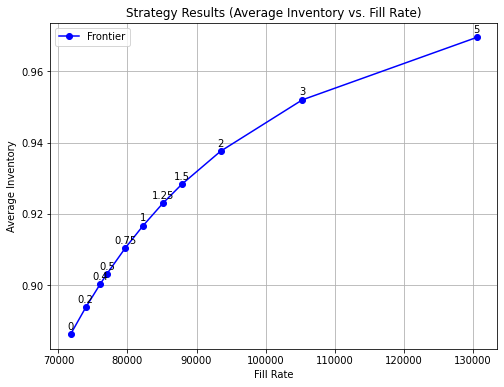

In [20]:
ss_factors = [0, 0.2, 0.4, 0.5, 0.75, 1, 1.25, 1.5, 2, 3, 5]
policy_results = compute_pareto(
    _forecast_func=FC_avg_n_days, _fc_factor=3,
    _ss_func = SS_on_forecast, _ss_factor=ss_factors,
    _up_to_level_func=up_to_level_on_forecast,
    _compute_stock_func=compute_stock, _order_rate=7
)
#results['dynamic'] = policy_results
plot_pareto(policy_results)

## Theoretical CSL: Up to level= Normal demand, Safety stock= x*sigma, Variable CSL (x=1.64 for 95% CSL)

#TODO : adapt to the log-normal data repartition

In [ ]:
# Theoretical CSL: Up to level= Normal demand, Safety stock= x*sigma, Variable CSL (x=1.64 for 95% CSL)
pipeline(forecast_func=FC_avg_n_days, fc_factor=3,                                       #forecast
         up_to_level_func=up_to_level_normal_demand, min_fill_rate=0.50,    #up to level
         compute_stock_func=compute_stock, order_rate=7, plot=True)                     #compute stock

In [ ]:
# Theoretical CSL: Up to level= Normal demand, Safety stock= x*sigma, Variable CSL (x=1.64 for 95% CSL)
pipeline(forecast_func=FC_avg_n_days, fc_factor=3,                                       #forecast
         up_to_level_func=up_to_level_lognormal_demand, min_fill_rate=0.50,    #up to level
         compute_stock_func=compute_stock, order_rate=7, plot=True)                     #compute stock

In [ ]:
fill_rates = [0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.98, 0.99]
policy_results = compute_pareto(
    _forecast_func=FC_avg_n_days, _fc_factor=3,
    _up_to_level_func=up_to_level_normal_demand, _min_fill_rate=fill_rates,
    _compute_stock_func=compute_stock, _order_rate=7
)
results['theoretical'] = policy_results
plot_pareto(policy_results)

In [ ]:
policy_results = compute_pareto(
    _forecast_func=FC_avg_n_days, _fc_factor=3,
    _up_to_level_func=up_to_level_lognormal_demand, _min_fill_rate=fill_rates,
    _compute_stock_func=compute_stock, _order_rate=7
)
results['theoretical'] = policy_results
plot_pareto(policy_results)

Fill rate: 88.62%
Average inventory: 71781.0
Average proportion of products not in stock: 9.65%
Fill rate: 89.37%
Average inventory: 73963.0
Average proportion of products not in stock: 8.99%
Fill rate: 90.02%
Average inventory: 76023.0
Average proportion of products not in stock: 8.46%
Fill rate: 90.31%
Average inventory: 77013.0
Average proportion of products not in stock: 8.22%
Fill rate: 91.04%
Average inventory: 79682.0
Average proportion of products not in stock: 7.60%
Fill rate: 91.67%
Average inventory: 82250.0
Average proportion of products not in stock: 7.09%
Fill rate: 92.30%
Average inventory: 85123.0
Average proportion of products not in stock: 6.52%
Fill rate: 92.83%
Average inventory: 87851.0
Average proportion of products not in stock: 6.07%
Fill rate: 93.76%
Average inventory: 93480.0
Average proportion of products not in stock: 5.25%
Fill rate: 95.20%
Average inventory: 105320.0
Average proportion of products not in stock: 3.95%


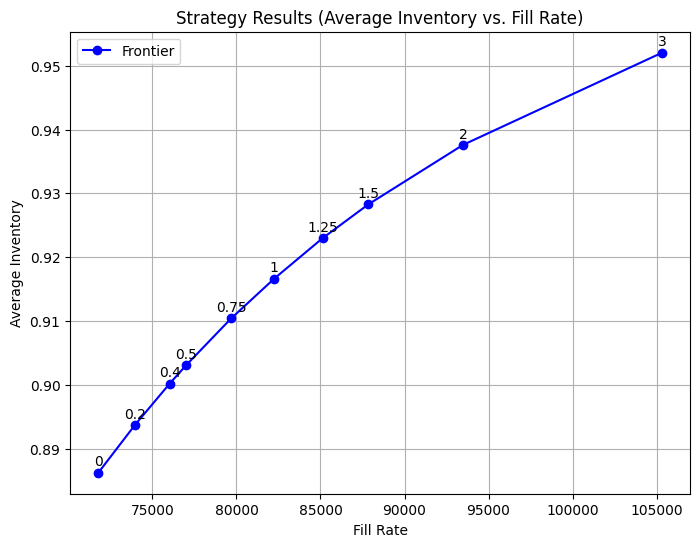

In [ ]:
ss_factors = [0, 0.2, 0.4, 0.5, 0.75, 1, 1.25, 1.5, 2, 3]
policy_results = compute_pareto(
    _forecast_func=FC_avg_n_days, _fc_factor=3,
    _ss_func = SS_on_forecast, _ss_factor=ss_factors,
    _up_to_level_func=up_to_level_on_forecast,
    _compute_stock_func=compute_stock, _order_rate=7
)
#results['dynamic'] = policy_results
plot_pareto(policy_results)

# (Q,s)
Q = forecast n next days

s = CSL dependent

In [ ]:
results = {}


/home/onyx/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/onyx/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/onyx/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/onyx/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/onyx/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/onyx/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero en

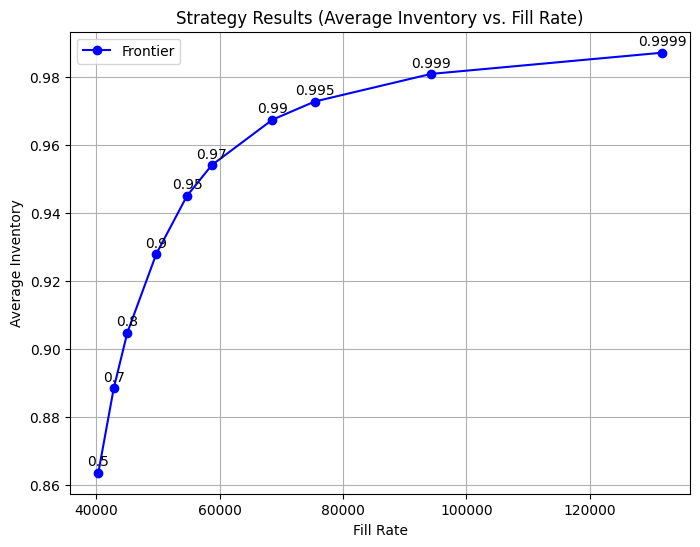

In [43]:
CSLs = [0.5, 0.7, 0.8, 0.9, 0.95, 0.99, 0.97, 0.995, 0.999, 0.9999]
df = load_data(pkl_path)
df = scraping_high_zeroes_products(df, 2000)
demand_matrix = preprocess_data(df)
forecast_matrix = FC_avg_n_days(demand_matrix, 3)

policy_results = compute_pareto_Q_s(
    demand_matrix=demand_matrix,
    forecast_matrix=forecast_matrix,
    CSLs=CSLs
)

results["(Q,s)"] = policy_results
plot_pareto(policy_results)

## Theoretical CSL: Up to level= Normal demand, Safety stock= x*sigma, Variable CSL (x=1.64 for 95% CSL)

#TODO : adapt to the log-normal data repartition

/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


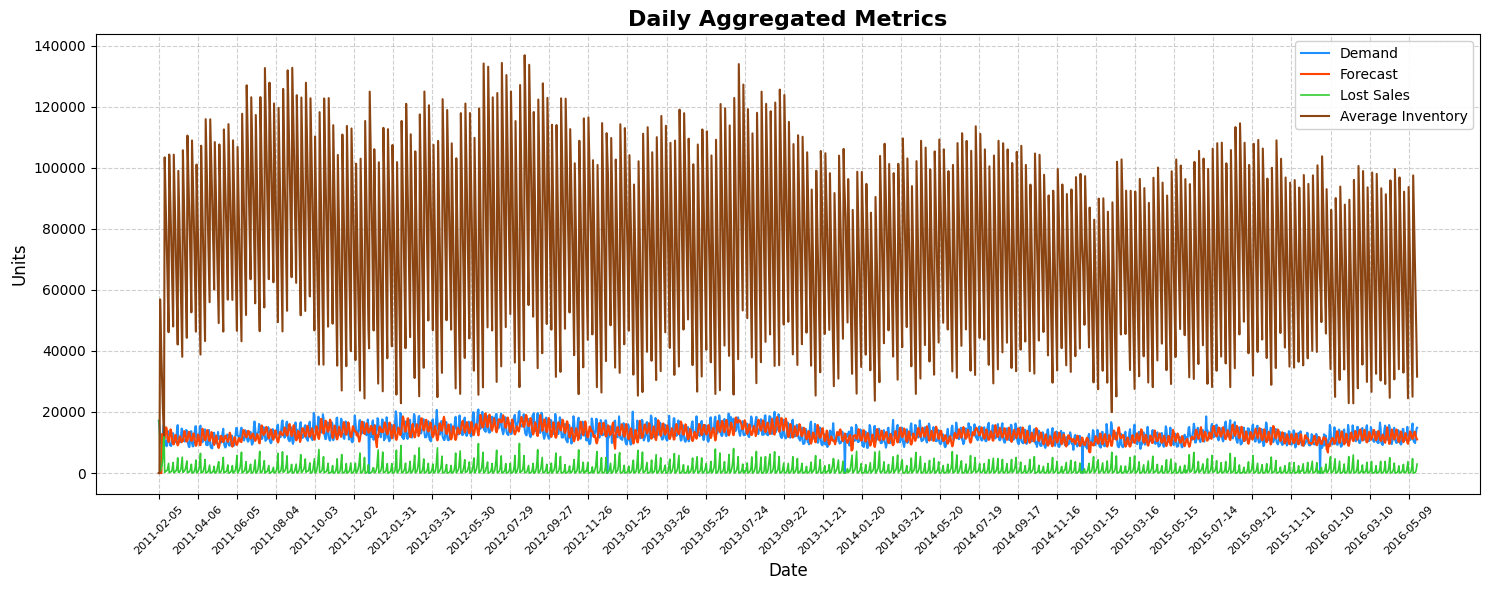

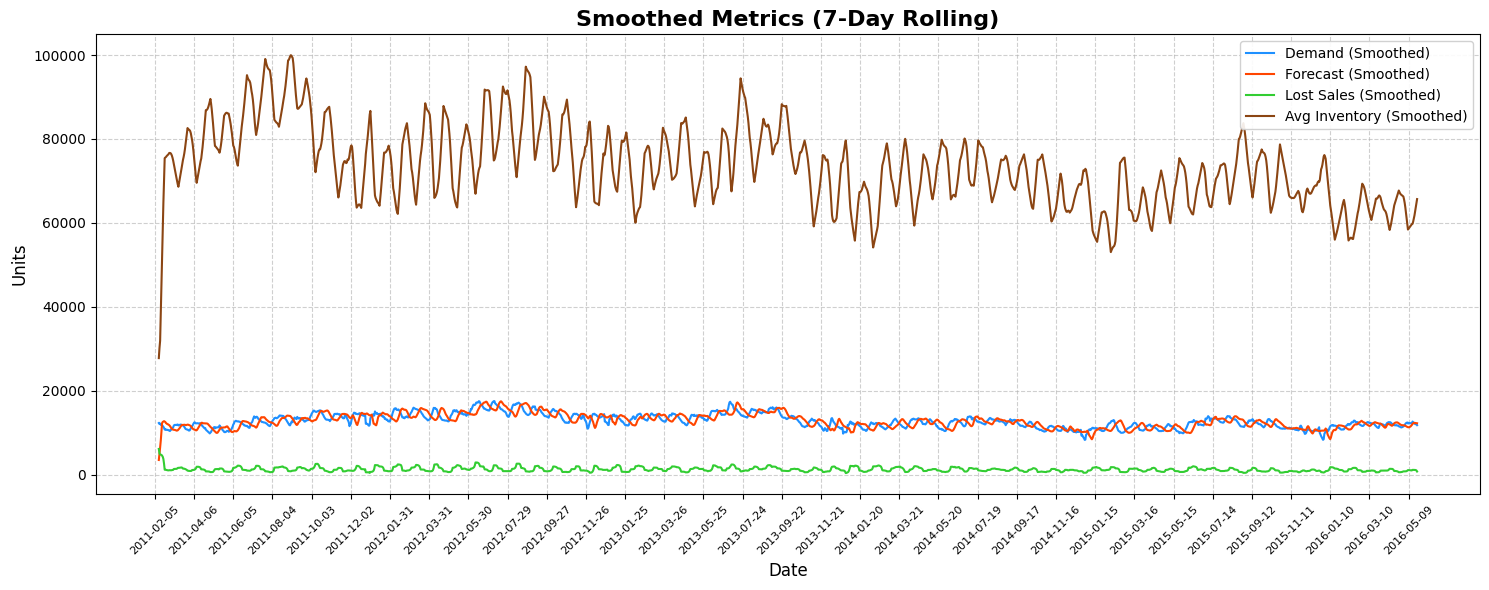

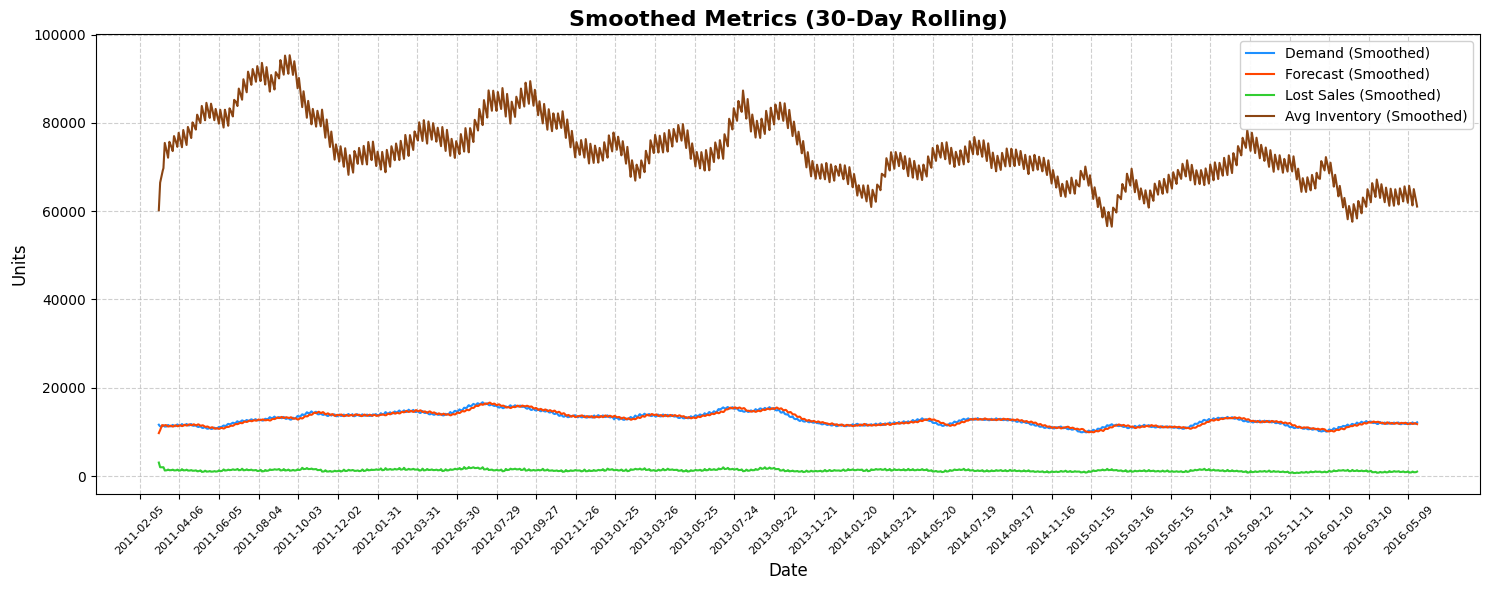

Fill rate: 89.71%
Average inventory: 73008.0
Average proportion of products not in stock: 8.60%


(0.8970986378937685, 73008.0, 0.0860489438433797)

In [58]:
# Theoretical CSL: Up to level= Normal demand, Safety stock= x*sigma, Variable CSL (x=1.64 for 95% CSL)
pipeline(forecast_func=FC_avg_n_days, fc_factor=3,                                       #forecast
         up_to_level_func=up_to_level_normal_demand, min_fill_rate=0.50,    #up to level
         compute_stock_func=compute_stock, order_rate=7, plot=True)                     #compute stock

In [ ]:
# Theoretical CSL: Up to level= Normal demand, Safety stock= x*sigma, Variable CSL (x=1.64 for 95% CSL)
pipeline(forecast_func=FC_avg_n_days, fc_factor=3,                                       #forecast
         up_to_level_func=up_to_level_lognormal_demand, min_fill_rate=0.50,    #up to level
         compute_stock_func=compute_stock, order_rate=7, plot=True)                     #compute stock

/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Fill rate: 99.30%
Average inventory: 108386.0
Average proportion of products not in stock: 0.57%


/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Fill rate: 99.56%
Average inventory: 135491.0
Average proportion of products not in stock: 0.31%


/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Fill rate: 99.62%
Average inventory: 152243.0
Average proportion of products not in stock: 0.26%


/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Fill rate: 99.67%
Average inventory: 176055.0
Average proportion of products not in stock: 0.22%


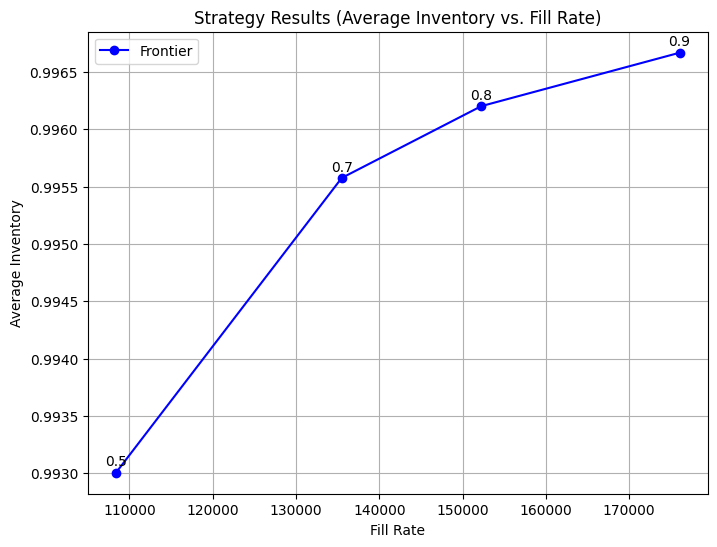

In [66]:
fill_rates = [0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.98, 0.99]
CSLs = [0.5, 0.7, 0.8, 0.9, 0.95, 0.99, 0.97, 0.995, 0.999, 0.9999]
CSLs = CSLs[:4]  # Limiter pour la démonstration
policy_results = compute_pareto(
    _forecast_func=FC_avg_n_days, _fc_factor=3,
    _up_to_level_func=up_to_level_normal_demand, _min_fill_rate=CSLs,
    _compute_stock_func=compute_stock, _order_rate=1
)
results['theoretical'] = policy_results
plot_pareto(results['theoretical'])

In [ ]:
policy_results = compute_pareto(
    _forecast_func=FC_avg_n_days, _fc_factor=3,
    _up_to_level_func=up_to_level_lognormal_demand, _min_fill_rate=fill_rates,
    _compute_stock_func=compute_stock, _order_rate=7
)
results['theoretical'] = policy_results
plot_pareto(policy_results)

In [51]:
results = {}

In [80]:
ss_factors = [0, 0.2, 0.4, 0.5, 0.75, 1, 1.25, 1.5, 2, 3]
CSLs = [0.2, 0.3, 0.4, 0.5, 0.7, 0.8, 0.9, 0.95, 0.99, 0.97, 0.995, 0.999, 0.9999]
n_rolling = [3, 7, 14]
n_same = [4, 8]

results['theoretical_CSL'] = compute_pareto(
        _forecast_func=FC_avg_n_days, _fc_factor=3,
        _up_to_level_func=up_to_level_normal_demand, _min_fill_rate=CSLs[:5],
        _compute_stock_func=compute_stock, _order_rate=1
    )
""" for n in n_rolling:
    results['moving_avg_'+ str(n) +'_dynamic'] = compute_pareto(
        _forecast_func=FC_avg_n_days, _fc_factor=n,
        _ss_func = SS_on_forecast, _ss_factor=ss_factors,
        _up_to_level_func=up_to_level_on_forecast,
        _compute_stock_func=compute_stock, _order_rate=1
    )
    results['moving_avg_'+ str(n) +'_Q_s'] = compute_pareto_Q_s(
        demand_matrix=demand_matrix,
        forecast_matrix=FC_avg_n_days(demand_matrix, n),
        CSLs=CSLs
    )
for n in n_same:
    results['same_days_avg_'+ str(n) +'_dynamic'] = compute_pareto(
        _forecast_func=FC_avg_n_same_days, _fc_factor=n,
        _ss_func = SS_on_forecast, _ss_factor=ss_factors,
        _up_to_level_func=up_to_level_on_forecast,
        _compute_stock_func=compute_stock, _order_rate=1
    )
    results['same_days_med_'+ str(n) +'_dynamic'] = compute_pareto(
        _forecast_func=FC_med_n_same_days, _fc_factor=n,
        _ss_func = SS_on_forecast, _ss_factor=ss_factors,
        _up_to_level_func=up_to_level_on_forecast,
        _compute_stock_func=compute_stock, _order_rate=1
    )
    results['same_days_avg_'+ str(n) +'_Q_s'] = compute_pareto_Q_s(
        demand_matrix=demand_matrix,
        forecast_matrix=FC_avg_n_same_days(demand_matrix, n),
        CSLs=CSLs
    )
    results['same_days_med_'+ str(n) +'_Q_s'] = compute_pareto_Q_s(
        demand_matrix=demand_matrix,
        forecast_matrix=FC_med_n_same_days(demand_matrix, n),
        CSLs=CSLs
    ) """



/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Fill rate: 96.57%
Average inventory: 68194.0
Average proportion of products not in stock: 4.60%


/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Fill rate: 98.38%
Average inventory: 82842.0
Average proportion of products not in stock: 1.79%


/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Fill rate: 99.02%
Average inventory: 96011.0
Average proportion of products not in stock: 0.90%


/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Fill rate: 99.30%
Average inventory: 108386.0
Average proportion of products not in stock: 0.57%


/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Fill rate: 99.56%
Average inventory: 135491.0
Average proportion of products not in stock: 0.31%


" for n in n_rolling:\n    results['moving_avg_'+ str(n) +'_dynamic'] = compute_pareto(\n        _forecast_func=FC_avg_n_days, _fc_factor=n,\n        _ss_func = SS_on_forecast, _ss_factor=ss_factors,\n        _up_to_level_func=up_to_level_on_forecast,\n        _compute_stock_func=compute_stock, _order_rate=1\n    )\n    results['moving_avg_'+ str(n) +'_Q_s'] = compute_pareto_Q_s(\n        demand_matrix=demand_matrix,\n        forecast_matrix=FC_avg_n_days(demand_matrix, n),\n        CSLs=CSLs\n    )\nfor n in n_same:\n    results['same_days_avg_'+ str(n) +'_dynamic'] = compute_pareto(\n        _forecast_func=FC_avg_n_same_days, _fc_factor=n,\n        _ss_func = SS_on_forecast, _ss_factor=ss_factors,\n        _up_to_level_func=up_to_level_on_forecast,\n        _compute_stock_func=compute_stock, _order_rate=1\n    )\n    results['same_days_med_'+ str(n) +'_dynamic'] = compute_pareto(\n        _forecast_func=FC_med_n_same_days, _fc_factor=n,\n        _ss_func = SS_on_forecast, _ss_factor=

In [81]:
results['moving*_avg_30_dynamic'] = compute_pareto(
        _forecast_func=FC_avg_n_days, _fc_factor=30,
        _ss_func = SS_on_forecast, _ss_factor=ss_factors,
        _up_to_level_func=up_to_level_on_forecast,
        _compute_stock_func=compute_stock, _order_rate=7
    )
results['moving*_med_14_dynamic'] = compute_pareto(
        _forecast_func=FC_med_n_days, _fc_factor=14,
        _ss_func = SS_on_forecast, _ss_factor=ss_factors,
        _up_to_level_func=up_to_level_on_forecast,
        _compute_stock_func=compute_stock, _order_rate=7
    )
results['moving*_med_30_dynamic'] = compute_pareto(
        _forecast_func=FC_med_n_days, _fc_factor=30,
        _ss_func = SS_on_forecast, _ss_factor=ss_factors,
        _up_to_level_func=up_to_level_on_forecast,
        _compute_stock_func=compute_stock, _order_rate=7
    )

Fill rate: 88.38%
Average inventory: 68017.0
Average proportion of products not in stock: 9.24%
Fill rate: 89.00%
Average inventory: 70258.0
Average proportion of products not in stock: 8.71%
Fill rate: 89.57%
Average inventory: 72511.0
Average proportion of products not in stock: 8.23%
Fill rate: 89.83%
Average inventory: 73642.0
Average proportion of products not in stock: 8.01%
Fill rate: 90.45%
Average inventory: 76520.0
Average proportion of products not in stock: 7.47%
Fill rate: 91.01%
Average inventory: 79419.0
Average proportion of products not in stock: 6.99%
Fill rate: 91.52%
Average inventory: 82391.0
Average proportion of products not in stock: 6.54%
Fill rate: 91.97%
Average inventory: 85372.0
Average proportion of products not in stock: 6.14%
Fill rate: 92.76%
Average inventory: 91426.0
Average proportion of products not in stock: 5.44%
Fill rate: 93.96%
Average inventory: 103835.0
Average proportion of products not in stock: 4.42%
Fill rate: 84.58%
Average inventory: 61

## Adaptative Variables

## ABC XYZ

In [ ]:
print("Number of elements in results:", len(results))

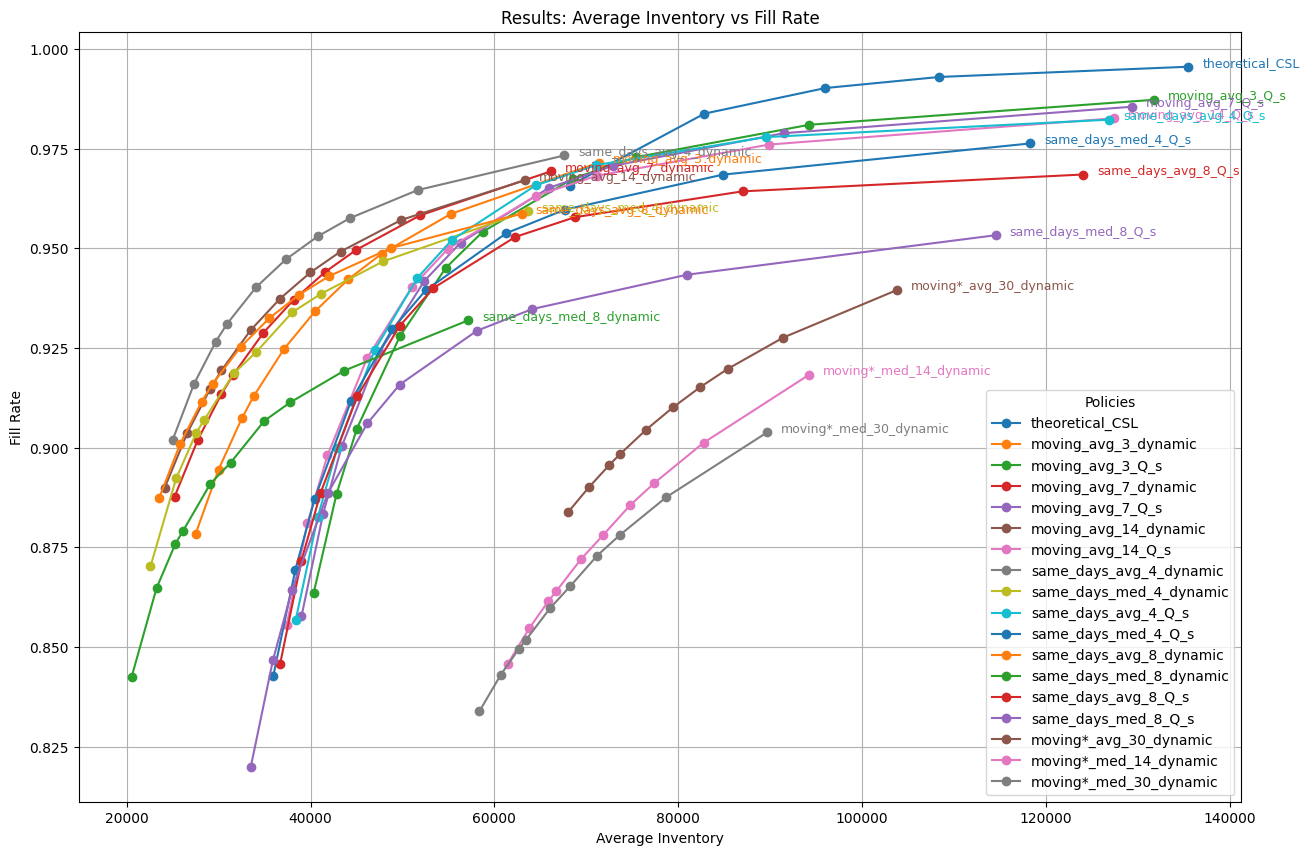

In [82]:
plot_results(results, filter=None)

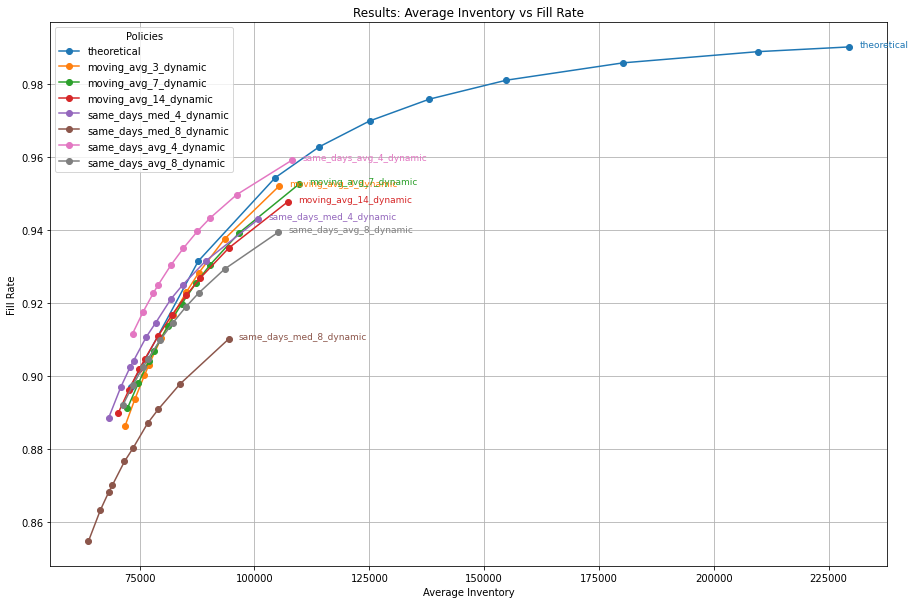

In [30]:
plot_results(results)

-pourquoi tant de difficulté à monter à 98-99% ?
-adaptative variables
-ABC XYZ

Dans utl modifier 3 jours par R & L

In [33]:
df = load_data(pkl_path)
df = scraping_high_zeroes_products(df, 1000)
demand_matrix = preprocess_data(df)

In [40]:
forecasts = {}
forecasts['FC_avg_3_days'] = FC_avg_n_days(demand_matrix, 3)
forecasts['FC_avg_7_days'] = FC_avg_n_days(demand_matrix, 7)
forecasts['FC_avg_14_days'] = FC_avg_n_days(demand_matrix, 14)
forecasts['FC_avg_4_same_days'] = FC_avg_n_same_days(demand_matrix, 4)
forecasts['FC_avg_8_same_days'] = FC_avg_n_same_days(demand_matrix, 8)
forecasts['FC_med_4_same_days'] = FC_med_n_same_days(demand_matrix, 4)
forecasts['FC_med_8_same_days'] = FC_med_n_same_days(demand_matrix, 8)


kpi_matrix = pd.DataFrame(columns=["MAPE", "RMSE", "MAE", "Bias (MFE)", "sMAPE"])

for name, forecast in forecasts.items():
    kpi_matrix.loc[name] = [
        mape(demand_matrix, forecast),
        rmse(demand_matrix, forecast),
        mae(demand_matrix, forecast),
        bias(demand_matrix, forecast),
        smape(demand_matrix, forecast)
    ]
    
print(kpi_matrix)

                         MAPE      RMSE       MAE  Bias (MFE)      sMAPE
FC_avg_3_days       79.771562  8.273261  4.429062   -0.004140  71.047152
FC_avg_7_days       72.302937  7.406196  3.962517   -0.000177  65.772967
FC_avg_14_days      70.748140  7.237507  3.884017   -0.001125  64.772305
FC_avg_4_same_days  71.314723  7.094645  3.867015   -0.001961  66.576348
FC_avg_8_same_days  68.344384  6.966209  3.768104    0.001181  64.593483
FC_med_4_same_days  71.131803  7.278245  3.945808   -0.323303  69.478044
FC_med_8_same_days  65.902628  7.250342  3.808710   -0.488395  66.698107
